<!--NAVIGATION-->
< [Regression Analysis](6-Regression_Analysis.ipynb) | [Contents](0-Index.ipynb) | [Cluster Analysis](8-Cluster_Analysis.ipynb)  >

# 7 Análise de Classificação

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/computational-chemical-biology/DataScience/blob/master/7-Classification_Analysis.ipynb)

 <a id="top"></a> <br>
**Conteúdo do *Notebook***
1. [Introdução à Análise de Classificação](#1)
2. [Regressão Logística](#2)
3. [Discriminante Linear](#3)
4. [Classificador dos K vizinhos mais próximos (KNN - *k-nearest neighbors*)](#4)
5. [Referências](#5)

<a id="1"></a> <br>
# 1 - Introdução à Análise de Classificação

Como discutido anteriormente na introdução da biblioteca [Scikit-Learn](2.4-Scikit-Learn_Library.ipynb), os modelos de regressão são comumente utilizados quando a variável reposta (Y), que se deseja predizer, é quantitativa. Existem ocasiões em que a variável que se deseja predizer é uma variável categórica. A predição de uma variável categórica implica em atribuir uma nova amostra ou observação a uma categoria ou classe. Nesta seção discutiremos classificadores que são amplamente adotados, com o foco no aprendizado dos conceitos de classificação.

Para ilustrar o conceito de classificação utilizaremos o conjunto de dados simulados sobre dívidas em cartão do livro <cite data-cite="236589/7WULH9A7"></cite>.

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

dividas = pd.read_csv('dados/dividas.tsv', sep='\t')
dividas.head()

,debito,estudante,balanco,renda
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


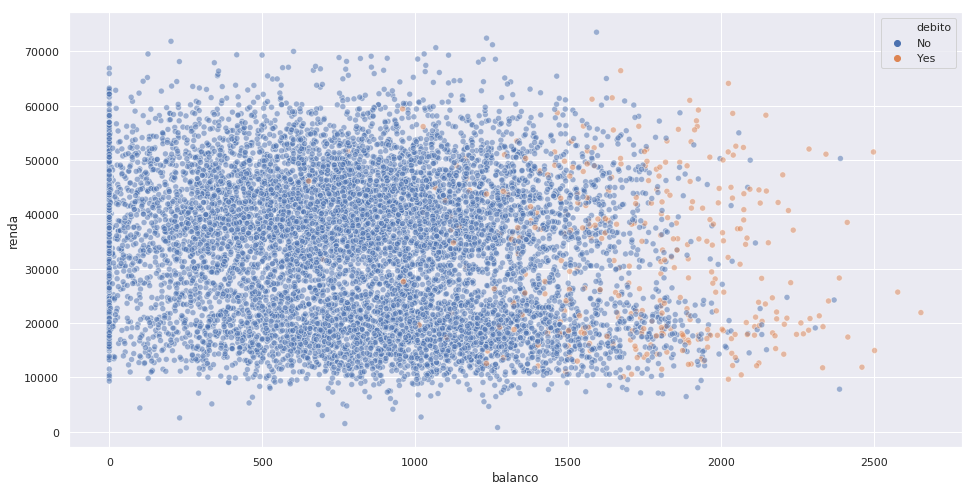

In [2]:
# visualizar o gráfico de dispersão
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(x="balanco", y="renda", hue='debito', data=dividas, alpha=0.5, ax=ax)

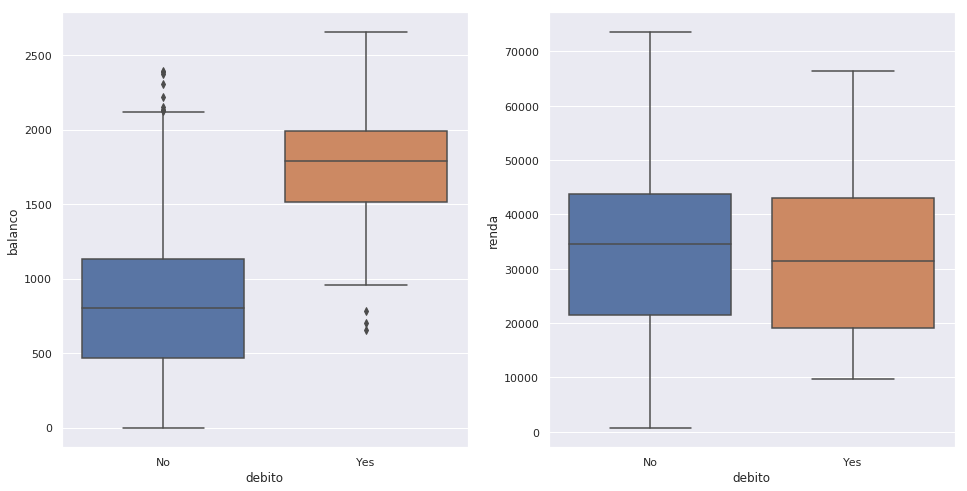

In [3]:
# Visualizar o 'diagrama de caixa' (boxplot)
fig, axs = plt.subplots(1,2, figsize=(16, 8))
sns.boxplot(x="debito", y="balanco", data=dividas, ax=axs[0])
sns.boxplot(x="debito", y="renda", data=dividas, ax=axs[1])

O objeto da classificação ilustrada aqui é predizer se um indivíduo vai deixar de pagar o cartão de crédito, com base na sua renda anual e balanço mensal do pagamento. O gráfico de dispersão (*scatter plot*) mostra que uma pequena fração (~3%) deixa de pagar o cartão. Indivíduos com maior balanço têm a tendência de não pagar o cartão, enquanto a relação com a renda não é tão clara.

<a id="2"></a> <br>
# 2 - Regressão Logística 

De forma geral, não existe uma forma natural de converter uma variável resposta qualitativa, com mais de dois níveis, em uma variável quantitativa, para utilizar os modelos de regressão vistos anteriormente. No modelo de regressão logística, ao invés de modelar a variável resposta Y diretamente, se modela a probabilidade de Y pertencer a uma categoria específica.

In [4]:
# Como visto na seção anterior primeiramente temos que 
# remodelar os dados
dividas['debito2'] = dividas.debito.factorize()[0]
dividas['estudante2'] = dividas.estudante.factorize()[0]
dividas.head()

,debito,estudante,balanco,renda,debito2,estudante2
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,0,1
2,No,No,1073.549164,31767.138947,0,0
3,No,No,529.250605,35704.493935,0,0
4,No,No,785.655883,38463.495879,0,0


In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Treinaremos um modelo com todos os dados
# para fins de ilustração do cálculo das probabilidades
# .reshape(-1, 1) cria um vetor (matriz (1xn))
X_treinamento = dividas.balanco.values.reshape(-1, 1)
y = dividas.debito2

# Ajustar o modelo
clf = LogisticRegression(solver='newton-cg')
clf.fit(X_treinamento, y)

# Simular valores para o balanço e
# calcular a probabilidade de cada
# classe com o modelo ajustado acima
X_teste = np.arange(dividas.balanco.min(), dividas.balanco.max()).reshape(-1,1)
prob = clf.predict_proba(X_teste)

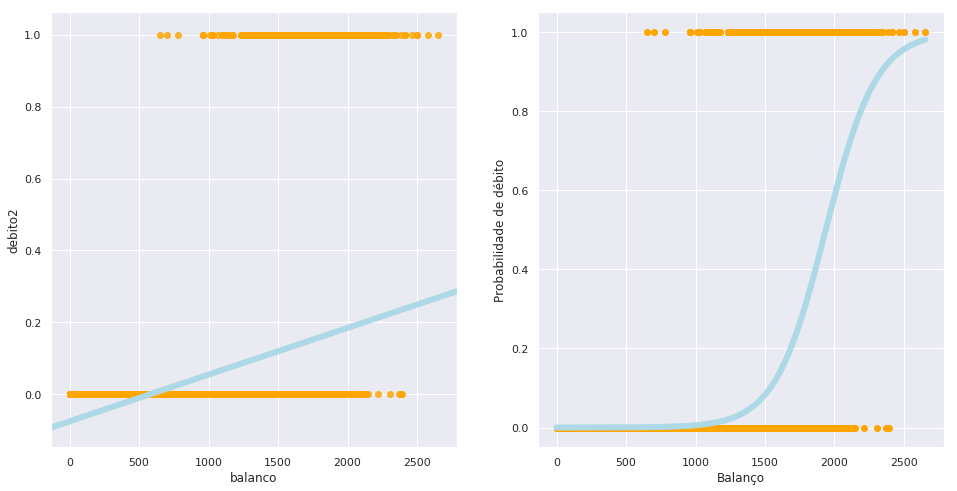

In [6]:
# Criar gráfico ilustrando o modelo de
# regressão logística
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

# Como uma regressão linear se comportaria
sns.regplot(dividas.balanco, dividas.debito2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':6}, ax=ax1)

# Como a regressão logística se comporta
ax2.scatter(X_treinamento, y, color='orange')
ax2.plot(X_teste, prob[:,1], color='lightblue', lw=6)
# Note a forma de mudar os rótulos do gráfico
ax2.set_ylabel('Probabilidade de débito')
ax2.set_xlabel('Balanço')

Quando uma reta é utilizada para tentar predizer a probabilidade de uma variável resposta binária é utilizada, um dos problemas que surgem é a predição de valores $p(X) < 0$ ou $p(X) > 0$, para os quais probabilidades não são válidas. Para evitar este problema, podemos utilizar uma função que retorna valores entre 0 e 1 independente dos valores de $X$. Na regressão logística, utilizamos a função logística:  

$ {\displaystyle p(X) = \frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}} } $

Para estimar os parâmetros $\beta$ como visto na seção anterior, se utiliza o método da máxima verossimilhança (*maximum likelihood*). A intuição por trás do método da máxima verossimilhança é buscar, por exemplo, os parâmetros $\beta_0$ e $\beta_1$ de modo que o valor estimado por $p(X)$ retorne o número de indivíduos que não pagaram o cartão mais próximo do observado, e um valor próximo de zero para indivíduos que pagaram. Este conceito é formalizado matematicamente como:

$\ell(\beta_0,\beta_1) = \prod_{i:y_i=1}p(x_i)\prod_{i':y_{i'}=0}(1-p(x_{i'}))$

In [7]:
# utilizaremos novamente a biblioteca Statsmodels para ilustrar
# o ajuste dos parâmetros
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

X_treinamento = sm.add_constant(dividas.balanco)
est = Logit(y.ravel(), X_treinamento).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


/home/rsilva/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balanco,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


In [8]:
# Como visto anteriormente, também podemos
# usar a biblioteca sklearn para acessar os
# coeficientes
print('Intercepto :', clf.intercept_)
print('Coeficiente: ', clf.coef_)

Intercepto : [-10.65132771]
Coeficiente:  [[0.00549892]]


In [9]:
# Para demonstrar o comportamento da função
# vamos criar uma função que calcula valores de
# p(X)
import math
e = math.e
def p_x(x1, b0, b1):
    p_x = e**(b0 + b1 * x1) / (1 + e**(b0 + b1 * x1))
    return p_x

print('Mínimo %f:' % dividas.balanco.min())
print('Máximo %f:' % dividas.balanco.max())

Mínimo 0.000000:
Máximo 2654.322576:


In [10]:
np.arange(dividas.balanco.min(), dividas.balanco.max(), 500)

array([   0.,  500., 1000., 1500., 2000., 2500.])

In [11]:
x1 = np.arange(dividas.balanco.min(), dividas.balanco.max(), 500)
b0 = -10.651331
b1 = 0.005499
[p_x(x, b0, b1) for x in x1]

[2.3668756538721678e-05,
 0.00036992843244007024,
 0.005752617973726007,
 0.08295707317934266,
 0.5858095877174325,
 0.9567344431741012]

In [12]:
# Repetindo a mesma predição com a biblioteca sklearn
clf.predict_proba(x1.reshape(-1,1))

array([[9.99976331e-01, 2.36688344e-05],
       [9.99630086e-01, 3.69913966e-04],
       [9.94247848e-01, 5.75215168e-03],
       [9.17052355e-01, 8.29476450e-02],
       [4.14230775e-01, 5.85769225e-01],
       [4.32741989e-02, 9.56725801e-01]])

In [13]:
help(clf.predict_log_proba)

Help on method predict_log_proba in module sklearn.linear_model.logistic:

predict_log_proba(X) method of sklearn.linear_model.logistic.LogisticRegression instance
    Log of probability estimates.
    
    The returned estimates for all classes are ordered by the
    label of classes.
    
    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
    
    Returns
    -------
    T : array-like, shape = [n_samples, n_classes]
        Returns the log-probability of the sample for each class in the
        model, where classes are ordered as they are in ``self.classes_``.



In [14]:
1-2.36687757e-05

0.9999763312243

<a id="3"></a> <br>
# 3 - Discriminante Linear 

A Análise de Discriminate Linear (do inglês *Linear Discriminant Analysis* - LDA) é comumente utilizada para reduzir as dimensões em técnicas de aprendizado de máquinas. O objetivo é projetar um conjunto de dados em um espaço de menores dimensões em que as categorias dos objetos em estudo possam ser discriminadas <cite data-cite="236589/Y67GF286"></cite>.

A abordagem utilizada no LDA é análoga a Análise de Componentes Principais, como veremos na próxima seção. No LDA estamos interessados nos componentes que maximizam a separação entre as categorias em estudo.

Podemos resumir o algoritmo do LDA em 5 etapas:

1. Calcular o vetor de médias das categorias de *d* dimensões do dados de interesse;
2. Calcular as matrizes de dispersão (matrizes dentro das classes e entre as classes);
3. Calcular os autovetores (*eigenvectors*) ($e_1, e_2, ... e_d$) e autovalores (*eigenvaluers*) ($\lambda_1, \lambda_2, ... \lambda_d$) para as matrizes de dispersão;
4. Ordene os autovetores pela ordem decrescente dos autovalores e selecione $k$ autovetores com os maiores autovalores para formar uma matriz $W$ de dimensões $d$ X $k$;
5. Utilize a matriz $W$ para transformar os valores das características das amostras em um novo sistema de coordenadas: $Y = XW$, onde $X$ é uma matriz de dimensões $n$ X $d$, com $n$ amostras, e $Y$  é uma matriz de dimensões $n$ X $k$ das coordenadas transformadas.

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns; sns.set()
iris = sns.load_dataset('iris') # carrega o conjunto de dados
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [16]:
iris['species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

In [17]:
# seleciona
X = iris.iloc[:,[0,1,2,3]].values # lembre-se dos índices implicítos
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [18]:
# utilizaremos o método LabelEncoder para modificar os valores
# de categorias para valores numéricos

dic_rotulos = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

y = iris['species'].values
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

Seguindo o algortimo descrito acima, começamos pelo cálculo das médias:

$m_i = \begin{bmatrix} 
\mu_{\omega_i (comprimento\ sépala)} \\
\mu_{\omega_i (largura\ sépala)} \\
\mu_{\omega_i (comprimento\ pétala)} \\
\mu_{\omega_i (largura\ pétala)}
\end{bmatrix}, com\ i = 1, 2, 3
$

In [19]:
mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Vetor de médias da classe %s: %s\n' %(cl, mean_vectors[cl-1]))

Vetor de médias da classe 1: [5.006 3.428 1.462 0.246]

Vetor de médias da classe 2: [5.936 2.77  4.26  1.326]

Vetor de médias da classe 3: [6.588 2.974 5.552 2.026]



A matriz de dispersão dentro das classes $S_w$ é calculada pela seguinte equação:

$ S_w = \sum_{i=1}^{C}S_i$

onde

$ S_i = \sum_{x\in{D_i}}^{n}(x-m_i)(x-m_i)^T $

e $m_i$ é o vetor de médias:

$ m_i = \frac{1}{n_i}\sum_{x\in{D_i}}^{n}x_k $

In [20]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # matriz de dispersão para cada classe
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # criar vetores coluna
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # somar matrizes de dispersão

print('Matriz de dispersão dentro das classes:\n', S_W)

Matriz de dispersão dentro das classes:
 [[38.9562 13.63   24.6246  5.645 ]
 [13.63   16.962   8.1208  4.8084]
 [24.6246  8.1208 27.2226  6.2718]
 [ 5.645   4.8084  6.2718  6.1566]]


A matriz de dispersão entre as classes $S_B$ é calculada pela seguinte equação:

$ S_B = \sum_{i=1}^{C}N_i(m_i-m)((m_i-m)^T$

onde 

$m$ é a média geral, e $m_i$ e $N_i$ são as médias e número de amostras para cada classe, respectivamente.

In [21]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # criar vetores coluna
    overall_mean = overall_mean.reshape(4,1) # criar vetores coluna
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('Matriz de dispersão entre classes:\n', S_B)

Matriz de dispersão entre classes:
 [[ 63.21213333 -19.95266667 165.2484      71.27933333]
 [-19.95266667  11.34493333 -57.2396     -22.93266667]
 [165.2484     -57.2396     437.1028     186.774     ]
 [ 71.27933333 -22.93266667 186.774       80.41333333]]


Seguindo as etapas do nosso algoritmo resolveremos a equação característica de autovalores e autovetores para a matriz:

$S_{w}^{-1}S_B$

para obter o discriminante linear

In [22]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nAutovetor {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Autovalor {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Autovetor 1: 
[[-0.20874182]
 [-0.38620369]
 [ 0.55401172]
 [ 0.7073504 ]]
Autovalor 1: 3.22e+01

Autovetor 2: 
[[-0.00653196]
 [-0.58661055]
 [ 0.25256154]
 [-0.76945309]]
Autovalor 2: 2.85e-01

Autovetor 3: 
[[-0.8751604 ]
 [ 0.23738055]
 [ 0.20437759]
 [ 0.36874728]]
Autovalor 3: -3.94e-15

Autovetor 4: 
[[ 0.29969903]
 [-0.41531345]
 [-0.47380021]
 [ 0.71638578]]
Autovalor 4: 5.01e-15


Podemos testar se os nossos cálculos satisfazem a equação característica

$A\nu = \lambda \nu$

onde 

$ A = S_{w}^{-1}S_B $

$\nu = Autovetor$

$\lambda = Autovalor $

In [23]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


Para selecionar os discriminantes para a projeção para o novo espaço selecionaremos os autovetores correspondentes aos maiores autovalores.

In [24]:
# Fazer lista de tuples (autovalor, autovetor)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Ordenar as tuples da maior para a menor
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Imprimir a lista de autovalores
print('Autovalores em ordem decrescente:\n')
for i in eig_pairs:
    print(i[0])

Autovalores em ordem decrescente:

32.191929198278025
0.28539104262307075
5.006103365681215e-15
3.939963213538599e-15


In [25]:
print('Variância explicada:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('Autovalores {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variância explicada:

Autovalores 1: 99.12%
Autovalores 2: 0.88%
Autovalores 3: 0.00%
Autovalores 4: 0.00%


Podemos então escolher os autovetores mais informativos, correspondendo aos dois primeiros autovalores, reduzindo as dimensões, de 5 características originais, para um sub-espaço de 2 dimensões:

In [26]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matriz W:\n', W.real)

Matriz W:
 [[-0.20874182 -0.00653196]
 [-0.38620369 -0.58661055]
 [ 0.55401172  0.25256154]
 [ 0.7073504  -0.76945309]]


Como ultima etapa do nosso algoritmo podemos transformar nossas variáveis para o sub-espaço aprendido, fazendo:

$ Y =XW $

In [27]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "Essa matriz não é de dimensões 150x2."

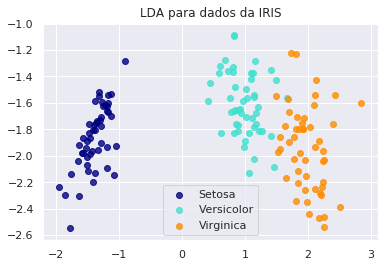

In [28]:
colors = ['navy', 'turquoise', 'darkorange']
target_names = ['Setosa', 'Versicolor', 'Virginica']
lw = 2

plt.figure()
for color, i, target_name in zip(colors, [1, 2, 3], target_names):
    plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], alpha=.8, color=color,
                label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA para dados da IRIS')

Podemos repetir o mesmo processo acima utilizando a biblioteca *sklearn* com a função `LinearDiscriminantAnalysis`. Note que as coordenadas podem ter valores invertidos, o que não importa para separação. No presente caso pode se observar que a posição relativa entre os pontos é mantida, assim como a separação entre as classes, objetivo da análise. 

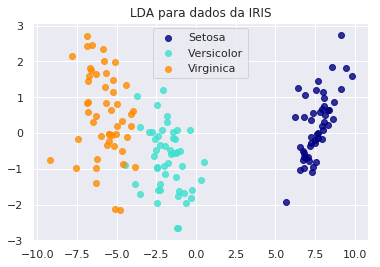

In [29]:
from sklearn.preprocessing import scale
X = scale(X)

target_names = ['Setosa', 'Versicolor', 'Virginica']

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

colors = ['navy', 'turquoise', 'darkorange']
lw = 2

plt.figure()
for color, i, target_name in zip(colors, [1, 2, 3], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA para dados da IRIS')

In [30]:
# http://www.di.fc.ul.pt/~jpn/r/discriminant_analysis/discriminant_analysis.html
vec = np.array([lda.scalings_[0,1], lda.scalings_[2,1]])
vec = vec / np.sqrt(np.sum(vec**2)) # escalonar o vetor para unidade
# Para projetar os pontos X em um vetor v calcule X.v.v^T
pontos_lda1 = X[:,[0,2]].dot(vec).reshape(150,1).dot(vec.reshape(1,2))

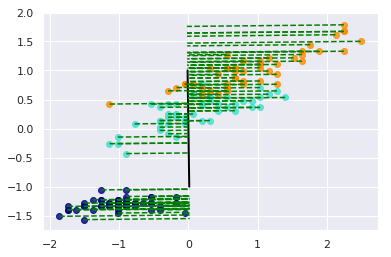

In [31]:
for color, i, target_name in zip(colors, [1, 2, 3], target_names):
    plt.scatter(X[y == i, 0], X[y == i, 2], alpha=.8, color=color,
                label=target_name)

plt.plot([-vec[0], vec[0]], [-vec[1], vec[1]], c='black',  linewidth=2)

for i in range(X.shape[0]):
    plt.plot([X[i,0], pontos_lda1[i,0]], [X[i,2], pontos_lda1[i,1]], '--', c='green')

<a id="4"></a> <br>
# 4 - Classificador dos K vizinhos mais próximos (KNN - *k-nearest neighbors*)

Muitas abordagens tentam estimar a distribuição condicional da variável resposta Y dada a distribuição das variáveis preditoras X, e assim classificar uma observação para a classe com a maior probabilidade estimada. Quando aplicamos o classificador dos K  vizinhos mais próximos (KNN), dado uma observação $x_0$, tenta identificar K pontos nos dados de treinamento que são mais próximos de $x_0$, representados por $N_0$ <cite data-cite="236589/7WULH9A7"></cite> <cite data-cite="236589/7JZ48ILR"></cite>.

In [33]:
# Exemplo do cálculo da distância euclideana
from math import sqrt
 
# calcule distância euclideana entre dois vetores
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)
 
# Utilize um pequeno conjunto de dados para testar
dados_teste = [[2.7810836,2.550537003,0],
    [1.465489372,2.362125076,0],
    [3.396561688,4.400293529,0],
    [1.38807019,1.850220317,0],
    [3.06407232,3.005305973,0],
    [7.627531214,2.759262235,1],
    [5.332441248,2.088626775,1],
    [6.922596716,1.77106367,1],
    [8.675418651,-0.242068655,1],
    [7.673756466,3.508563011,1]]
row0 = dados_teste[0]
for row in dados_teste:
    distance = euclidean_distance(row0, row)
    print(distance)

0.0
1.3290173915275787
1.9494646655653247
1.5591439385540549
0.5356280721938492
4.850940186986411
2.592833759950511
4.214227042632867
6.522409988228337
4.985585382449795


In [34]:
# Encontre o vizinho mais próximo
def get_neighbors(train, test_row, num_neighbors):
    distances = list()
    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

neighbors = get_neighbors(dados_teste, dados_teste[0], 3)
for neighbor in neighbors:
    print(neighbor)

[2.7810836, 2.550537003, 0]
[3.06407232, 3.005305973, 0]
[1.465489372, 2.362125076, 0]


In [36]:
# Faça a predição da classificação com os vizinhos
def predict_classification(train, test_row, num_neighbors):
    neighbors = get_neighbors(train, test_row, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction
 
prediction = predict_classification(dados_teste, dados_teste[0], 3)
print('Expected %d, Got %d.' % (dados_teste[0][-1], prediction))

Expected 0, Got 0.


Podemos também obter o valor de *k* que retorna a maior acurácia para o modelo.

In [37]:
# Carregar as bibliotecas
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Carregar os dados da Iris
iris = datasets.load_iris()

# Separar em X (características) e y (rótulos)
X = iris.data
y = iris.target

# dividir o conjunto de dados em conjuntos de treinamento e teste
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.3, random_state=5)

# escalonar os dados antes de treinar o modelo
sc_x = StandardScaler()
X_treinamento = sc_x.fit_transform(X_treinamento)
X_teste = sc_x.transform(X_teste)

# Aplicar o classificador knn com diferentes valores k aos dados da Iris 
# para encontrar o k baseado na melhor acurácia
for k in range(2,30):
    classifier = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    classifier.fit(X_treinamento, y_treinamento)
    y_preds = classifier.predict(X_teste)
    print("A acurácia para k =", k, "é:", accuracy_score(y_teste, y_preds))    

A acurácia para k = 2 é: 0.9333333333333333
A acurácia para k = 3 é: 0.9333333333333333
A acurácia para k = 4 é: 0.9333333333333333
A acurácia para k = 5 é: 0.9555555555555556
A acurácia para k = 6 é: 0.9777777777777777
A acurácia para k = 7 é: 0.9555555555555556
A acurácia para k = 8 é: 0.9555555555555556
A acurácia para k = 9 é: 0.9555555555555556
A acurácia para k = 10 é: 0.9777777777777777
A acurácia para k = 11 é: 0.9777777777777777
A acurácia para k = 12 é: 0.9777777777777777
A acurácia para k = 13 é: 0.9333333333333333
A acurácia para k = 14 é: 0.9555555555555556
A acurácia para k = 15 é: 0.9555555555555556
A acurácia para k = 16 é: 0.9333333333333333
A acurácia para k = 17 é: 0.9333333333333333
A acurácia para k = 18 é: 0.9333333333333333
A acurácia para k = 19 é: 0.9333333333333333
A acurácia para k = 20 é: 0.9555555555555556
A acurácia para k = 21 é: 0.9555555555555556
A acurácia para k = 22 é: 0.9555555555555556
A acurácia para k = 23 é: 0.9111111111111111
A acurácia para k 

<a id="5"></a> <br>
# 5 - Referências
<div class="cite2c-biblio"></div>

###### [Voltar ao topo](#top)

<!--NAVIGATION-->
< [Regression Analysis](6-Regression_Analysis.ipynb) | [Contents](0-Index.ipynb) | [Cluster Analysis](8-Cluster_Analysis.ipynb)  >